# Project 2 - Ames Housing Model

## Model Version 1: Preparing dataframe and fitting simple linear model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#given paths and dataframe names 
train_path = "datasets/train.csv"
test_path = "datasets/test.csv"

train_m1 = pd.read_csv(train_path)
test_m1 = pd.read_csv(test_path)

In [3]:
#see shape of imported df
train_m1.shape

(2051, 81)

In [4]:
#find columns with lots of nulls
series_nulls = train_m1.isna().sum().sort_values(ascending = False)
pd.DataFrame(series_nulls).head(6)

,0
Pool QC,2042
Misc Feature,1986
Alley,1911
Fence,1651
Fireplace Qu,1000
Lot Frontage,330


We see that there are 6 columns with >329 null values, which is >16% of rows.

For our purposes we will drop these columns. For future versions of the model we could see if improvements could be made by keeping a few of them.

In [5]:
train_m1.drop(columns = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Lot Frontage'], inplace = True)

In [6]:
#Look at reamining null columns
series_nulls = train_m1.isna().sum().sort_values(ascending = False)
pd.DataFrame(series_nulls).head(10)

,0
Garage Finish,114
Garage Yr Blt,114
Garage Qual,114
Garage Cond,114
Garage Type,113
Bsmt Exposure,58
BsmtFin Type 2,56
Bsmt Qual,55
BsmtFin Type 1,55
Bsmt Cond,55


For Garage and Basement columns, not having a value means its safe to assume that house does not have a garage or basement. We can leave those columns alone

In [7]:
#drop the 1 row with null for garage area
train_m1 = train_m1[~train_m1['Garage Area'].isnull()]

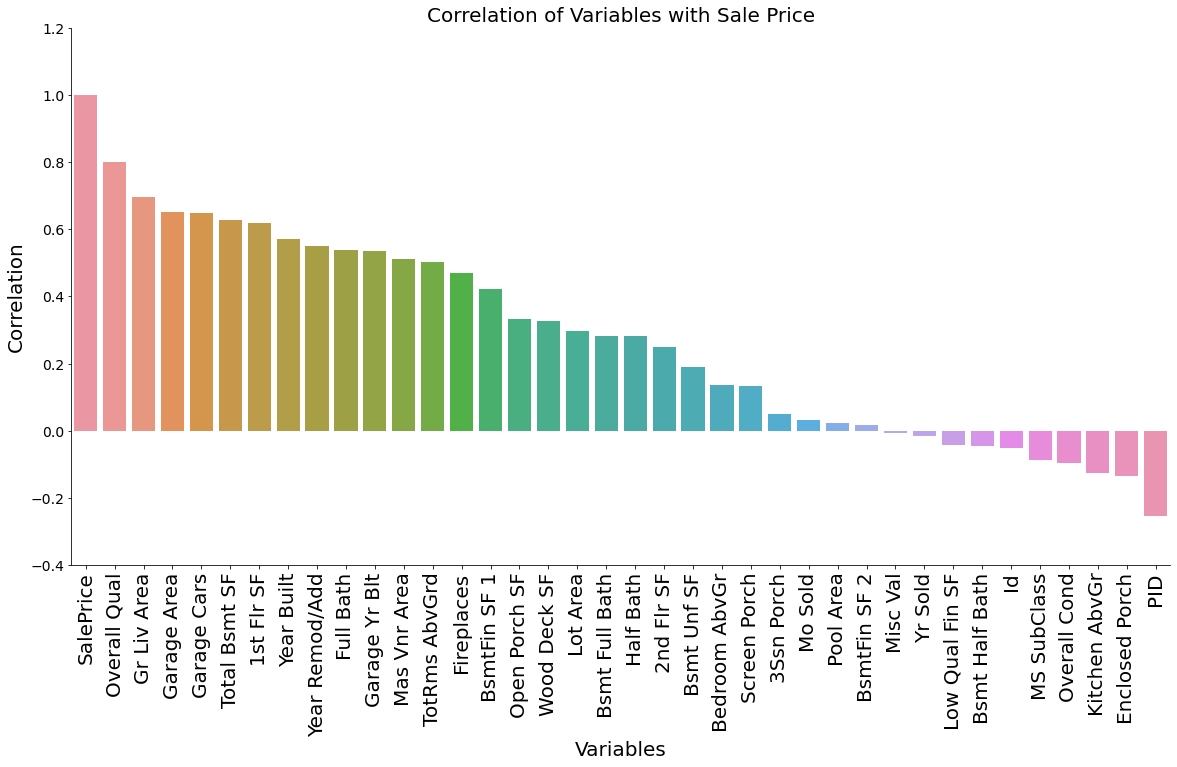

In [8]:
#get the 10 columns most correlated with saleprice
corrs = pd.DataFrame(train_m1.corr()['SalePrice'].sort_values(ascending=False))
corrs.index
corrs.reset_index(level = 0, inplace = True)
corrs.columns = ['variable', 'coefficient']

#Using a catplot for this is inspired by github user at-tan: https://github.com/at-tan/Cracking_Ames_Housing_OLS/blob/master/Ames_regression.ipynb
w.set_xticklabels(rotation=90, size = 20)
w.set_yticklabels(size = 14)
plt.title('Correlation of Variables with Sale Price', fontsize=20)
plt.xlabel("Variables", size=20)
plt.ylabel("Correlation", size=20)
w.savefig('Correlations.png', bbox_inches = 'tight')
plt.show()


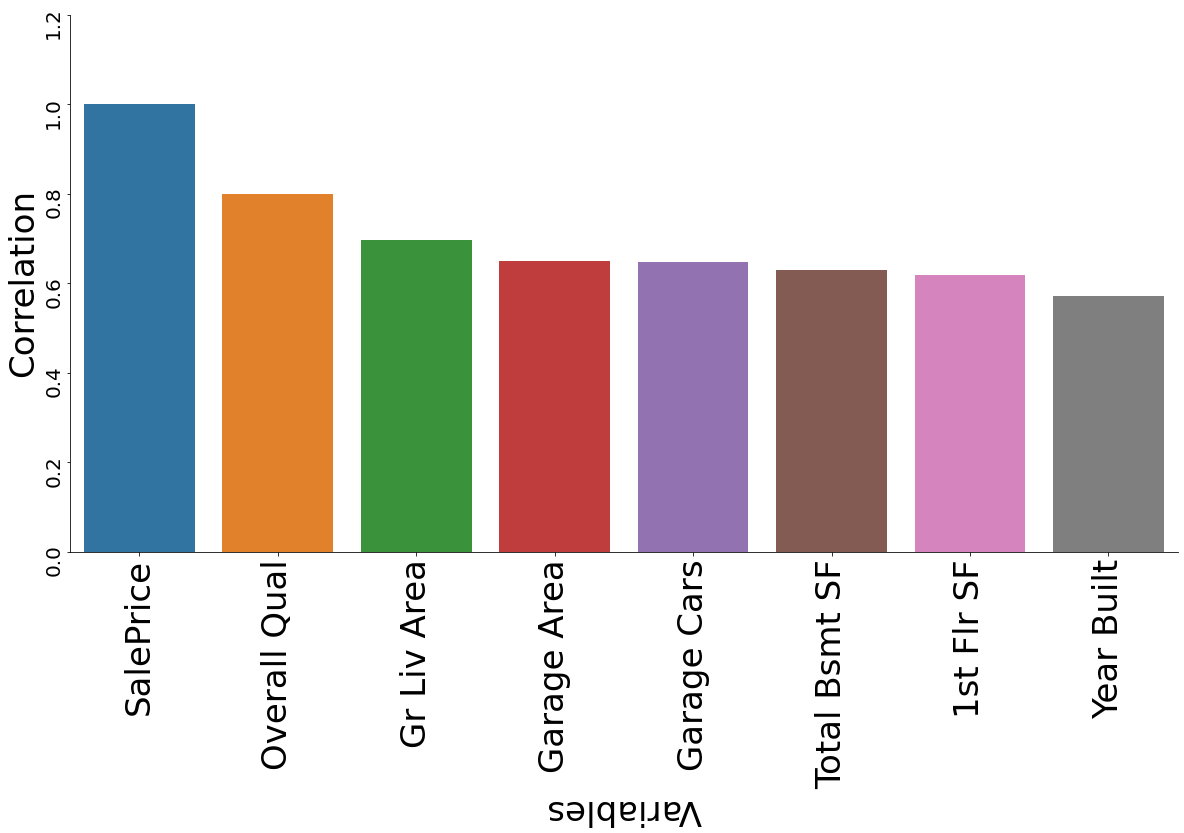

In [9]:
#get the 10 columns most correlated with saleprice
corrs = pd.DataFrame(train_m1.corr()['SalePrice'].sort_values(ascending=False)[:8])
corrs.index
corrs.reset_index(level = 0, inplace = True)
corrs.columns = ['variable', 'coefficient']

#Using a catplot for this is inspired by github user at-tan: https://github.com/at-tan/Cracking_Ames_Housing_OLS/blob/master/Ames_regression.ipynb
w =sns.catplot(x='variable', y='coefficient', data=corrs, kind='bar', height=8, aspect=2)
w.set_xticklabels(rotation=90, size = 34)
w.set_yticklabels(rotation = 90, size = 20)
#plt.title('Correlation of Variables with Sale Price', fontsize=20)
plt.xlabel( "Variables", size=34, rotation = 180)
plt.ylabel("Correlation", size=34)
w.savefig('Correlations2.png', bbox_inches = 'tight')
plt.show()

In [10]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Year Built']
X = train_m1[features]
y = train_m1['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y)

We selected these features because we believe they have high correlation with price and little multicollinearity. We only have one variable that measures living space size, etc.

If, for example, we had selected both 'Garage Area' and 'Garage Cars' we would have had a problem with multicollinearity. Both of those columns are measures of garage size so they are very highly correlated. That's why we did not include 'Garage Cars' in the model even though it has one of the highest correlations with price.

In later iterations of the model, we could try to measure multicollinearity so to better minimize it.

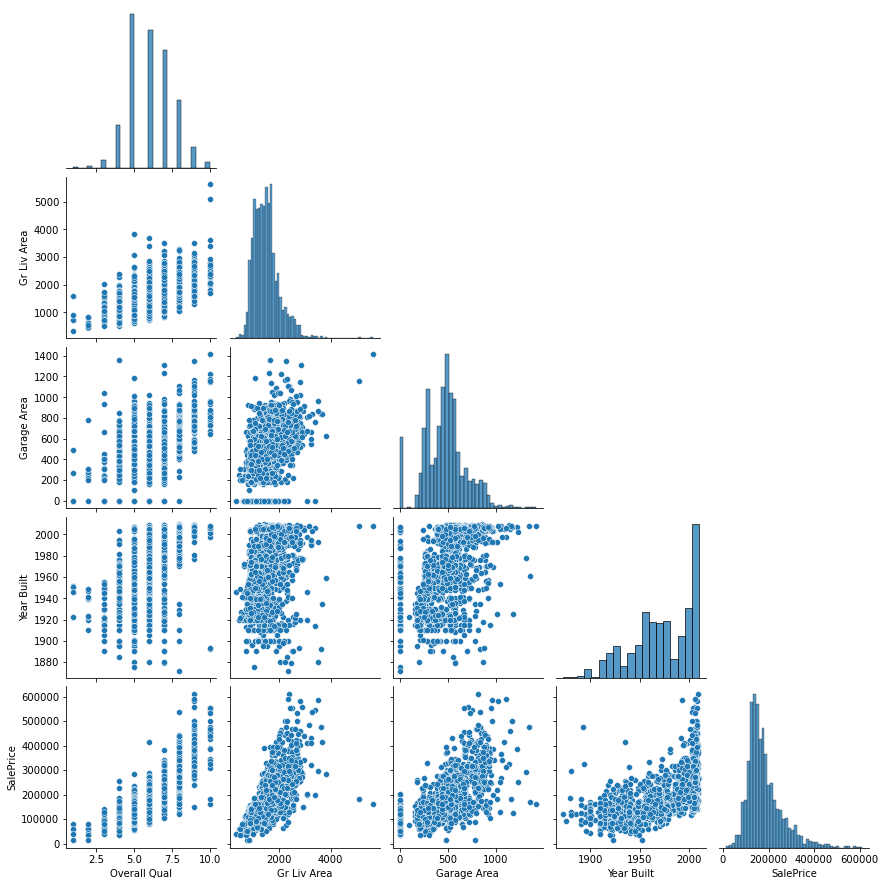

In [11]:
#Use pairplot to look for linear relationships and normality
features_price = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Year Built', 'SalePrice']
sns.pairplot(train_m1[features_price], corner = True);

The histograms above show that Overall Quality, Above Ground Living Area, Garage Area, and Sale Price have approximately normal distributions. The distribution of Year Built is not normal. A larger portion of our dataset is comprised of houses built in recent years.

The bottom row of scatter plots shows the relationships between our features and Sale Price. Overall Quality and Above Ground Living Area have the best linear relationship with price. Garage Area does not fit the linear relationship very closely but a general positive correlation between Garage Area and Price can be seen.

Of our features, Year Built is worst for fitting a linear relationship. Until 1950, there seems to be no correlation between Year Built and Price. Between 1950 and 2000 there is a positive correlation. After 2000 we see there is once again little correlation. In future versions of the model we could separate Year Built into buckets based on what we observed.


### Create Model

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

### Model Version 1 Residuals

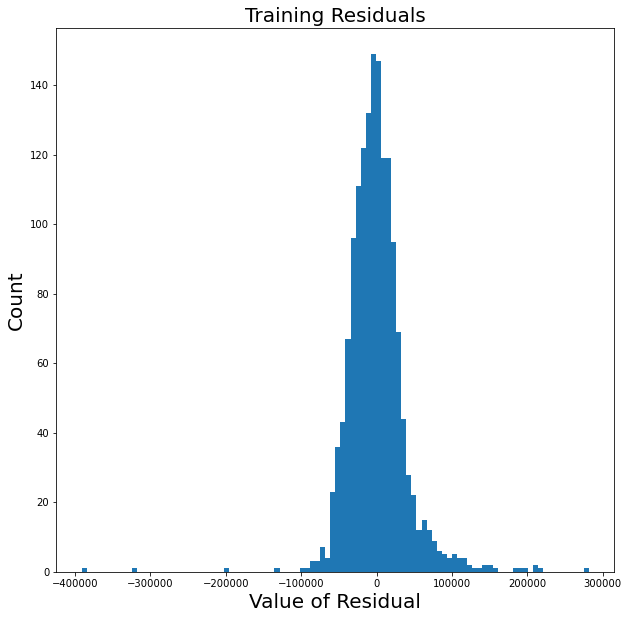

Training Residuals Mean: 0.0


In [13]:
#create training predictions array
training_predictions = lr.predict(X_train)

#create residuals array
resids = y_train - training_predictions

myfig = plt.figure(figsize = (10,10))

plt.hist(resids, bins = 100);
plt.xlabel('Value of Residual', size = 20)
plt.ylabel('Count', size = 20);
plt.title('Training Residuals', size = 20);
plt.show()
print('Training Residuals Mean:', round(resids.mean(),5))

This histogram shows that the Model 1 training residuals follow an approximately normal distribution. This is good because residual normaility is one of the important assumptions of any linear regression.

The mean of the residuals is zero which is a good sign. Mathematically, if the mean of my residuals was not zero that would increase the expected error of the model predictions.

## Model Version 1: Score

In [14]:
print('Mean Sale Price:', round(np.mean(train_m1['SalePrice'])))

print('MSE:', round(mean_squared_error(y_test, preds, squared=False)))

print('Cross Val Score:', round(cross_val_score(lr,X,y, cv = 5).mean(),5))

print('Training Score:', round(lr.score(X_train, y_train),5))

print('Test Score:', round(lr.score(X_test, y_test), 5))

Mean Sale Price: 181485
MSE: 36536
Cross Val Score: 0.76914
Training Score: 0.75715
Test Score: 0.79855


Model V1's MSE is about 40,000. The mean sale price in the training dataset is 181,485. This means our model predictions are off by roughly 22% on average.

This isn't bad considering we only have four features and we have not dont any feature engineering yet. In the Model v2 we'll see if we can improve the model's accuracy using feature engineering.

The difference between the training score and the test score of Model v1 is only about .03. It's good to have similar test scores and training scores. The fact that our training score is very slightly higher than our test score indicates that Model v1 may be slightly overfit.

As we work on Model v2 we'll hope to increase the predictive accuracy while maintaining the successes of model v1.

## Model V1 Conclusion

Model v1 Successes:
1. Easy to understand (only four features, simple linear regresion)
2. Little correlation between features
2. Normal residuals
4. Similar training score and test score (only sligtly overfit)

Model v1 Weaknesses to be addressed in Model v2:
1. No feature engineering
2. Accuracy could be improved

# Model Version 2

In [15]:
#given paths and dataframe names 
train_path = "datasets/train.csv"
test_path = "datasets/test.csv"

train_m2 = pd.read_csv(train_path)
test_m2 = pd.read_csv(test_path)

## Feature Engineering

In this section we will add additional features to our training dataframe. Feature engineering allows us to increase the accuracy of our model. One example of feature engineering is adding columns that are the interaction terms of existing features. 

To do this we will use SK Learn's PolynomialFeatures. This tool will generate interaction columns for all four of the features we used in Model v1.



In [16]:
from sklearn.preprocessing import PolynomialFeatures

In [17]:
#drop the 1 row with null for garage area
train_m2 = train_m2[~train_m2['Garage Area'].isnull()]

In [18]:
#these are the same features used in Model v1
X = train_m2[features]

# Instantiate PolynomialFeatures
poly = PolynomialFeatures(include_bias = False)

#create polynomial featueres
X_poly = poly.fit_transform(X)

#get names of features
features_m2 = poly.get_feature_names(features)

# View X_poly in a DataFrame
X_poly_df = pd.DataFrame(X_poly, columns = poly.get_feature_names(features))
X_poly_df.head()

,Overall Qual,Gr Liv Area,Garage Area,Year Built,Overall Qual^2,Overall Qual Gr Liv Area,Overall Qual Garage Area,Overall Qual Year Built,Gr Liv Area^2,Gr Liv Area Garage Area,Gr Liv Area Year Built,Garage Area^2,Garage Area Year Built,Year Built^2
0,6.0,1479.0,475.0,1976.0,36.0,8874.0,2850.0,11856.0,2187441.0,702525.0,2922504.0,225625.0,938600.0,3904576.0
1,7.0,2122.0,559.0,1996.0,49.0,14854.0,3913.0,13972.0,4502884.0,1186198.0,4235512.0,312481.0,1115764.0,3984016.0
2,5.0,1057.0,246.0,1953.0,25.0,5285.0,1230.0,9765.0,1117249.0,260022.0,2064321.0,60516.0,480438.0,3814209.0
3,5.0,1444.0,400.0,2006.0,25.0,7220.0,2000.0,10030.0,2085136.0,577600.0,2896664.0,160000.0,802400.0,4024036.0
4,6.0,1445.0,484.0,1900.0,36.0,8670.0,2904.0,11400.0,2088025.0,699380.0,2745500.0,234256.0,919600.0,3610000.0


In [19]:
#set up X and y for M2 regression
X = X_poly_df
y = train_m2['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
preds = lr2.predict(X_test)

### Model Version 2 Residuals

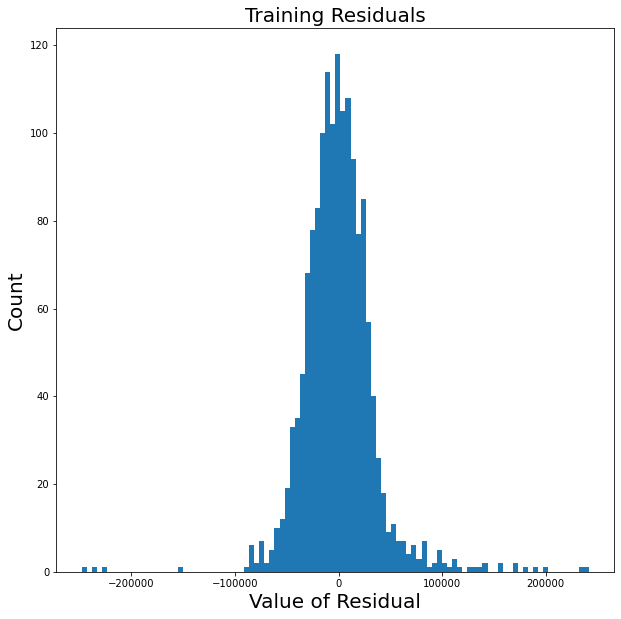

Training Residuals Mean: -0.0


<Figure size 432x288 with 0 Axes>

In [21]:
#create training predictions array
training_predictions = lr2.predict(X_train)

#create residuals array
resids = y_train - training_predictions

myfig = plt.figure(figsize = (10,10))

plt.hist(resids, bins = 100);
plt.xlabel('Value of Residual', size = 20)
plt.ylabel('Count', size = 20);
plt.title('Training Residuals', size = 20);
plt.show()
print('Training Residuals Mean:', round(resids.mean(),5))
plt.savefig('%M!Residuals.png', bbox_inches = 'tight', dpi=myfig.dpi);

In [22]:
print('Mean Sale Price:', round(np.mean(train_m2['SalePrice'])))

print('MSE:', round(mean_squared_error(y_test, preds, squared=False)))

print('Cross Val Score:', round(cross_val_score(lr2,X,y, cv = 5).mean(),5))

print('Training Score:', round(lr2.score(X_train, y_train),5))

print('Test Score:', round(lr2.score(X_test, y_test), 5))

Mean Sale Price: 181485
MSE: 29025
Cross Val Score: 0.8112
Training Score: 0.81223
Test Score: 0.85153


The Mean Squared Error of Model v2 is about 36,000, which is an improvement of about 4000 from model v1. This increase in accuracy can be attributed to Polynomial Features, which increases the accuracy of our model by considering the interactions between features.

Model V1's training score was higher than its test score, indicating it may be slightly overfit. Model v2 is the opposite: it's test score is slightly higher, so it might be underfit.

It might be surprising that adding more features with feature engineering made Model v2 less overfit, and even underfit. But adding more features doesn't necessarily cause over fitness. Over fitness is caused by adding in noise and random fluctuations. Adding useful features like the interaction terms between features can increase model accuracy and reduce over fitness.


## Generate Submission File

To apply our model 2 linear regression to the testing data we need to add the polynomial feature columns to the testing dataframe.

In [23]:
#these are the same features used in Model v1
X = test_m2[features]

#create polynomial featueres
X_test_poly = poly.transform(X)

#get names of features
features_m2 = poly.get_feature_names(features)

# View X_poly in a DataFrame
X_test_poly_df = pd.DataFrame(X_test_poly, columns = poly.get_feature_names(features))

In [24]:
# Submission
X_submission = X_test_poly_df
pred_submission = lr2.predict(X_submission)


# Put our submissions in kaggle's test data
test_m2['SalePrice'] = pred_submission
# Make our submission dataframe
submission = test_m2[['Id', 'SalePrice']].sort_values(by='Id')

from datetime import date
today = date.today().strftime("%d_%m_%y")

# Write to csv
submission.to_csv(f"Jack_Olson_Model_{today}.csv", index=False)
submission.head()


,Id,SalePrice
703,2,125873.123890
705,4,237664.994621
119,6,186315.146469
311,7,230910.299417
400,17,254824.018902
